# Behavior cloning to train DNN agents for shiftable loads

In [1]:
using DataFrames, CSV
using BSON: @save, @load
using BSON, NPZ
using TOML
using Flux, MLJ
using StatsBase
using Random
using Plots, Plots.Measures
using Revise, HEMS

ENV["COLUMNS"] = 2000
Random.seed!(1)

TaskLocalRNG()

In [2]:
## Plots default
default(; labelfontsize = 13, tickfontsize = 11,
    framestyle = :box,
    margin = 0.5mm,
    legendfontsize=11,
    xticks=:auto
)

## Read expert dataset

In [3]:
root_dir = "../../"

home_dir = joinpath(root_dir, "data/home/")
IL_data_dir = joinpath(root_dir, "data/learning/IL")
IL_model_dir = joinpath(root_dir, "model/IL")
img_dir = joinpath(root_dir, "img")
;

In [4]:
h = read_home_config(joinpath(home_dir, "home.toml"));

In [5]:
# `d` and `dt` are training set and test set respectively
@load joinpath(IL_data_dir, "train_xy.bson") d

dt = BSON.load(joinpath(IL_data_dir, "test_xy.bson"))[:d];
keys(dt)

KeySet for a Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}} with 6 entries. Keys:
  "EV"
  "AC1"
  "AC2"
  "DW"
  "H"
  "WM"

## Train agents for shiftable loads
- Train a DNN-based agent 
- Report performance 
- Store the obtained agent

We empirically found that the same set of hyperparameters worked well for all shiftable loads in this study.

In [6]:
function report_classification_perf(agent, X, y)

    ŷ = vec(agent(X) .>= 0.5) 
    acc = MLJ.accuracy(ŷ, y)
    # cm = MLJ.confusion_matrix(coerce(ŷ, OrderedFactor), coerce(y, OrderedFactor))
    cm = MLJ.confusion_matrix(categorical(ŷ; ordered = true), categorical(y; ordered = true))
    f1 = MLJ.f1score(ŷ, y)
    @show cm acc f1
    nothing
end

report_classification_perf (generic function with 1 method)

In [7]:
agents = Agent[]
shiftable_loads = [l["id"] for l in Iterators.Flatten((h["SU"], h["SI"]))]
loss_histories = []
shiftable_loads

3-element Vector{String}:
 "WM"
 "DW"
 "EV"

In [8]:
@time begin
for id in shiftable_loads
    X, y = d[id]
    Xt, yt = dt[id]
    @show id size(X) size(Xt)
    
    agent, loss_hist = train_SU_agent(X, y; device = Flux.cpu, epochs = 500, η = 0.2e-2,
        report_freq = 0, w1 = 2.5)
    push!(agents, agent)
    push!(loss_histories, loss_hist)
end
end

id = "WM"
size(X) = (3, 3655)
size(Xt) = (3, 1825)
id = "DW"
size(X) = (3, 2193)
size(Xt) = (3, 1095)
id = "EV"
size(X) = (4, 5848)
size(Xt) = (4, 2920)
 79.070252 seconds (89.48 M allocations: 25.077 GiB, 4.35% gc time, 54.02% compilation time)


┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0013333333333333333
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0008888888888888888
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0005925925925925926
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0003950617283950617
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0002633744855967078
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.0001755829903978052
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Info: No improvement in 10 epochs. Drop learning rate to
│   η = 0.00011705532693187012
└ @ HEMS f:\github\HEMS-IL\src\HEMS\src\IL\BC.jl:149
┌ Inf

id = "EV"
ne = 196


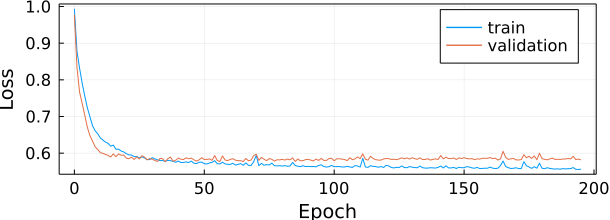

In [13]:
wi = 3  # which shiftable load 
loss_hist = loss_histories[wi]
id = shiftable_loads[wi]
ne = size(loss_hist)[1]
@show id ne
plot(; size = (610, 220), xlabel = "Epoch", ylabel = "Loss")
plot!(0:ne-1, loss_hist; label=["train" "validation"], bottom_margin=3.5mm, top_margin=-1mm, left_margin=1.5mm, right_margin=1.5mm)
savefig(joinpath(img_dir, "train_$(id).pdf"))
current()

In [10]:
for (id, agent) in zip(shiftable_loads, agents)
    @show id
    X, y = d[id]
    Xt, yt = dt[id]
    println("- Training performance")
    report_classification_perf(agent, X, y)
    println("- Test performance")
    report_classification_perf(agent, Xt, yt)
end

id = "WM"
- Training performance
cm = MLJBase.ConfusionMatrixObject{2}([2683 131; 241 600], ["0.0", "1.0"])
acc = 0.8982216142270862
f1 = 0.7633587786259542
- Test performance
cm = MLJBase.ConfusionMatrixObject{2}([1201 111; 259 254], ["0.0", "1.0"])
acc = 0.7972602739726027
f1 = 0.5785876993166287
id = "DW"
- Training performance
cm = MLJBase.ConfusionMatrixObject{2}([1311 67; 151 664], ["0.0", "1.0"])
acc = 0.9005927952576379
f1 = 0.8589909443725744
- Test performance
cm = MLJBase.ConfusionMatrixObject{2}([544 48; 186 317], ["0.0", "1.0"])
acc = 0.7863013698630137
f1 = 0.7304147465437788
id = "EV"
- Training performance
cm = MLJBase.ConfusionMatrixObject{2}([1767 124; 1157 2800], ["0.0", "1.0"])
acc = 0.7809507523939808
f1 = 0.8138351983723296
- Test performance
cm = MLJBase.ConfusionMatrixObject{2}([864 81; 596 1379], ["0.0", "1.0"])
acc = 0.7681506849315068
f1 = 0.8029112081513828


┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\shuhu\.julia\packages\MLJBase\GxHVg\src\measures\confusion_matrix.jl:112
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\shuhu\.julia\packages\MLJBase\GxHVg\src\measures\confusion_matrix.jl:112
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\shuhu\.julia\packages\MLJBase\GxHVg\src\measures\confusion_matrix.jl:112
┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\shuhu\.julia\packages\MLJBase\GxHVg\src\measures\confusion_matrix.jl:112
┌ Warning: The classes are un-ordere

In [11]:
@save joinpath(IL_model_dir, "agents.bson") agents=Dict(id => agent for (id, agent) in zip(shiftable_loads, agents))